SAMEER KHATWANI  
PRN: 22070126099  

Github repo - https://github.com/samisafk/DCGAN

# Deep Convolutional Generative Adversarial Networks (DCGAN)
## Introduction
DCGAN is a type of GAN architecture that utilizes deep convolutional networks for stable and high-quality image generation.

## Architecture
- The generator consists of fractionally-strided convolutions (deconvolutions) to upscale noise vectors.
- The discriminator is a deep convolutional network with LeakyReLU activations to classify images as real or fake.

## Training
- The generator learns to produce realistic images.
- The discriminator learns to distinguish between real and generated images.
- Both models are trained using backpropagation and the Adam optimizer.

## Expected Output
- The trained generator can generate high-quality images similar to those in the dataset.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [32]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [33]:
# Hyperparameters
image_size = 64
batch_size = 256  # Increased batch size for faster training
nz = 100  # Latent vector size
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
num_epochs = 25
lr = 0.0002
beta1 = 0.5

In [34]:
# Load CelebA dataset
dataset = dset.ImageFolder(root="./data/celeba",  
                      transform=transforms.Compose([
                          transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


In [35]:
# Initialize model weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [36]:
# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [37]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [38]:
# Initialize models
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [39]:
# Use BCEWithLogitsLoss (more stable than BCELoss)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


In [40]:
# Training Loop
real_label = 1.0
fake_label = 0.0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [41]:
print("Starting Training...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        
        optimizerD.zero_grad()
        output_real = discriminator(real_images)
        lossD_real = criterion(output_real, label_real)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        lossD_fake = criterion(output_fake, label_fake)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        optimizerG.zero_grad()
        output_fake = discriminator(fake_images)
        lossG = criterion(output_fake, label_real)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(dataloader)}] LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    vutils.save_image(fake, f"generated_epoch_{epoch+1}.png", normalize=True)

print("Training completed.")

Starting Training...
Epoch [1/25] Step [0/763] LossD: 1.3419, LossG: 3.3393
Epoch [1/25] Step [100/763] LossD: 0.0961, LossG: 4.5980
Epoch [1/25] Step [200/763] LossD: 1.5516, LossG: 8.6425
Epoch [1/25] Step [300/763] LossD: 0.5491, LossG: 4.2089
Epoch [1/25] Step [400/763] LossD: 0.5492, LossG: 4.8554
Epoch [1/25] Step [500/763] LossD: 0.5480, LossG: 3.5217
Epoch [1/25] Step [600/763] LossD: 1.1005, LossG: 2.8993
Epoch [1/25] Step [700/763] LossD: 0.5405, LossG: 4.2061
Epoch [2/25] Step [0/763] LossD: 0.6036, LossG: 3.1972
Epoch [2/25] Step [100/763] LossD: 0.4936, LossG: 4.3747
Epoch [2/25] Step [200/763] LossD: 0.4933, LossG: 4.6809
Epoch [2/25] Step [300/763] LossD: 0.7013, LossG: 4.3068
Epoch [2/25] Step [400/763] LossD: 0.7444, LossG: 5.2012
Epoch [2/25] Step [500/763] LossD: 0.4135, LossG: 3.4370
Epoch [2/25] Step [600/763] LossD: 0.6512, LossG: 2.9055
Epoch [2/25] Step [700/763] LossD: 0.4127, LossG: 3.0487
Epoch [3/25] Step [0/763] LossD: 0.4392, LossG: 3.1130
Epoch [3/25] Ste

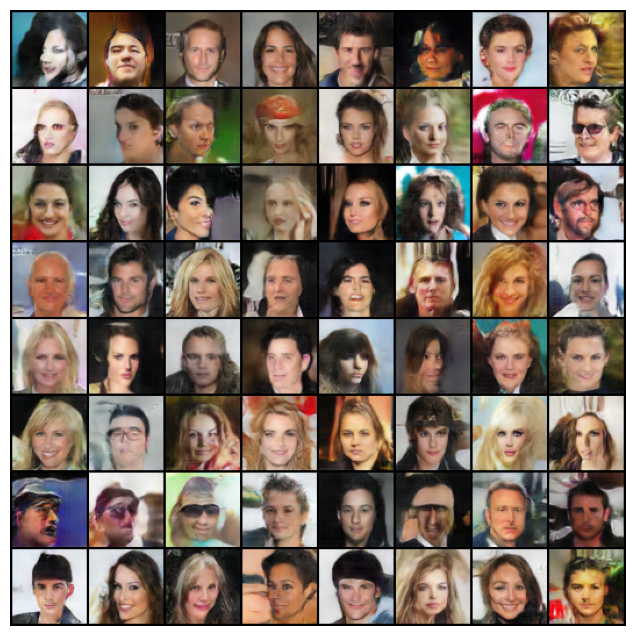

In [43]:
# Display the last generated image
import matplotlib.pyplot as plt
from PIL import Image

generated_image_path = f"generated_epoch_{num_epochs}.png"
img = Image.open(generated_image_path)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img)
plt.show()

In [44]:
from torchsummary import summary

# Print Generator structure
print("Generator Architecture:")
summary(generator, (100, 1, 1))  # Input size (nz, 1, 1)

# Print Discriminator structure
print("\nDiscriminator Architecture:")
summary(discriminator, (3, 64, 64))  # Input size (3, 64, 64)


Generator Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Ta

In [49]:
from torchviz import make_dot

# Generate sample noise vector
noise = torch.randn(1, 100, 1, 1, device=device)

# Forward pass through the generator
fake_img = generator(noise)

# Generate and display model visualization
dot = make_dot(fake_img, params=dict(generator.named_parameters()))
dot.format = "png"
dot.render("generator_structure")
dot.view()


'generator_structure.png'